In [70]:
# LIBRARIES AND MODULES REQUIRED FOR THIS MODEL

import pandas as pd
import numpy as np
import seaborn as sns
import shap
import warnings
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier



%matplotlib inline
warnings.filterwarnings('ignore')

In [64]:
# Creating a .csv file from .data file
column_names = [
    "animal_name", "hair", "feathers", "eggs", "milk", "airborne", "aquatic",
    "predator", "toothed", "backbone", "breathes", "venomous", "fins",
    "legs", "tail", "domestic", "catsize", "class_type"
]

df = pd.read_csv("zoo.csv", names=column_names)
df = df.drop(columns=["animal_name"])  

# Remove rows that contain any non-numeric values where numbers are expected
df = df[~df.apply(lambda row: row.astype(str).str.contains('legs').any(), axis=1)]

df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
1,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
2,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
3,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
4,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
5,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


## UNDERSTANDING OUR DATASET

In [4]:
df.shape


(101, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 1 to 101
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hair        101 non-null    object
 1   feathers    101 non-null    object
 2   eggs        101 non-null    object
 3   milk        101 non-null    object
 4   airborne    101 non-null    object
 5   aquatic     101 non-null    object
 6   predator    101 non-null    object
 7   toothed     101 non-null    object
 8   backbone    101 non-null    object
 9   breathes    101 non-null    object
 10  venomous    101 non-null    object
 11  fins        101 non-null    object
 12  legs        101 non-null    object
 13  tail        101 non-null    object
 14  domestic    101 non-null    object
 15  catsize     101 non-null    object
 16  class_type  101 non-null    object
dtypes: object(17)
memory usage: 14.2+ KB


In [6]:
# Convert all binary columns to numeric
binary_features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 
                   'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'tail', 
                   'domestic', 'catsize']

for col in binary_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

X = df.drop(columns=['class_type'])
y = df['class_type']

# Convert 'legs' to numeric, handling errors by coercing to NaN
df['legs'] = pd.to_numeric(df['legs'], errors='coerce')
df = df.dropna(subset=['legs'])

# show the updated DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 1 to 101
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hair        101 non-null    int64 
 1   feathers    101 non-null    int64 
 2   eggs        101 non-null    int64 
 3   milk        101 non-null    int64 
 4   airborne    101 non-null    int64 
 5   aquatic     101 non-null    int64 
 6   predator    101 non-null    int64 
 7   toothed     101 non-null    int64 
 8   backbone    101 non-null    int64 
 9   breathes    101 non-null    int64 
 10  venomous    101 non-null    int64 
 11  fins        101 non-null    int64 
 12  legs        101 non-null    int64 
 13  tail        101 non-null    int64 
 14  domestic    101 non-null    int64 
 15  catsize     101 non-null    int64 
 16  class_type  101 non-null    object
dtypes: int64(16), object(1)
memory usage: 14.2+ KB


In [7]:
df.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000


In [8]:
print(df['legs'].unique())


[4 0 2 6 8 5]


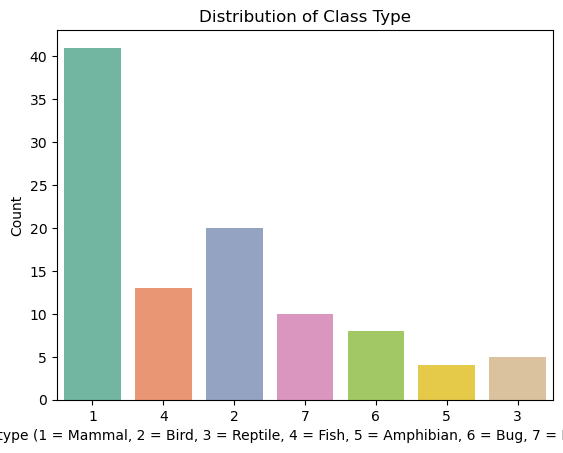

In [9]:
# Count plot of Class Type using Seaborn
sns.countplot(x='class_type', data=df, palette='Set2')
plt.title('Distribution of Class Type')
plt.xlabel('class_type (1 = Mammal, 2 = Bird, 3 = Reptile, 4 = Fish, 5 = Amphibian, 6 = Bug, 7 = Invertebrate)')
plt.ylabel('Count')
plt.show()

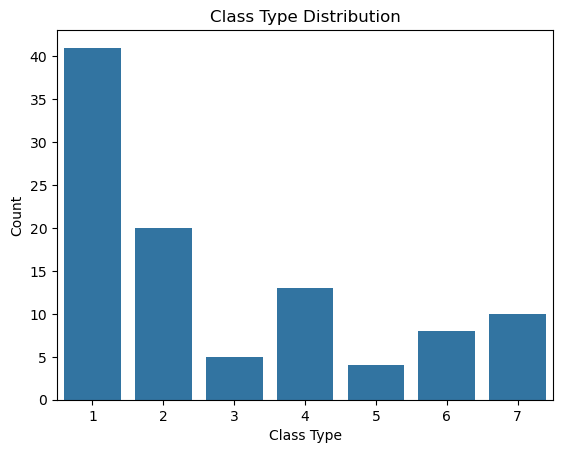

In [10]:
# Sort the class labels before plotting using matplotlib and seaborn
sorted_classes = sorted(df['class_type'].dropna().unique())

sns.countplot(x='class_type', data=df, order=sorted_classes)
plt.title("Class Type Distribution")
plt.xlabel("Class Type")
plt.ylabel("Count")
plt.show()


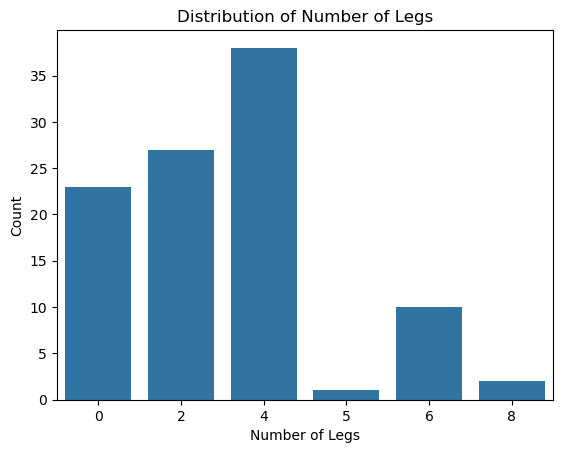

In [11]:
# Using Matplotlib and seaborn

sns.countplot(x='legs', data=df)
plt.title("Distribution of Number of Legs")
plt.xlabel("Number of Legs")
plt.ylabel("Count")
plt.show()



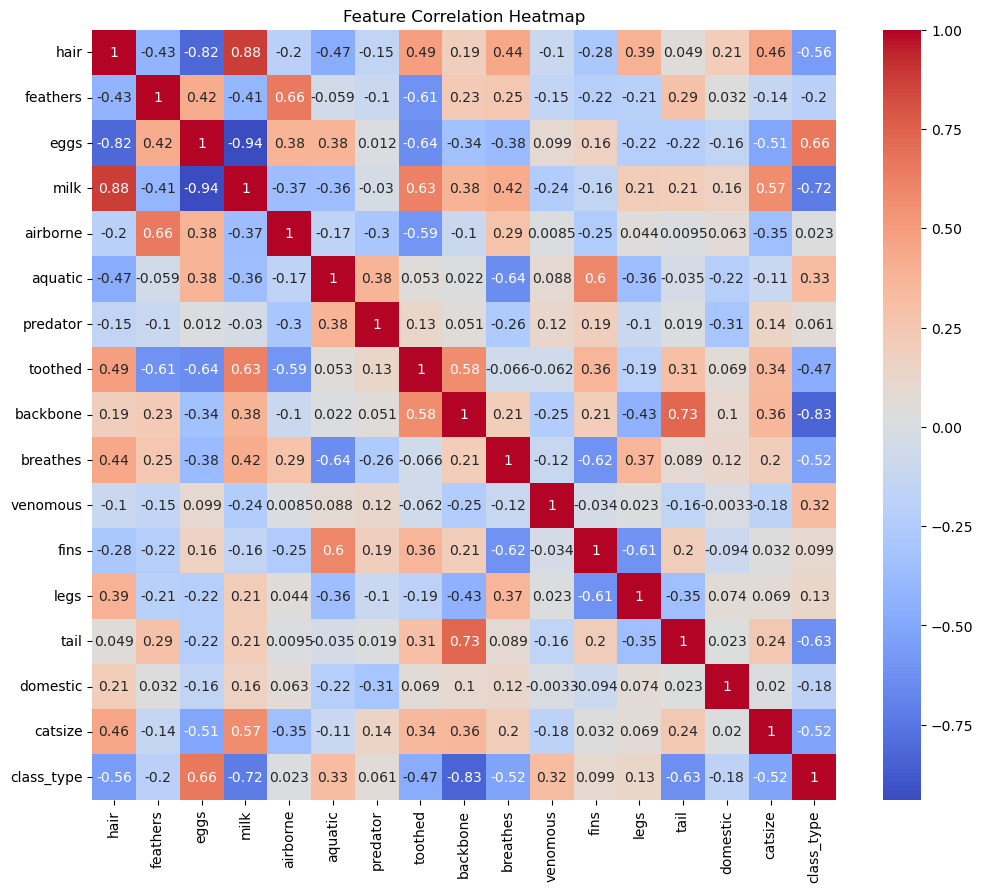

In [12]:
# Correlation Heatmap of Distribution
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


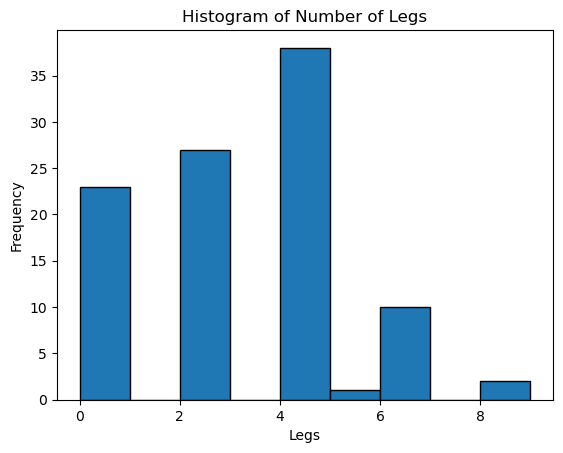

In [13]:
# Histogram of Leg feature distribution
plt.hist(df['legs'], bins=range(0, 10), edgecolor='black')
plt.title("Histogram of Number of Legs")
plt.xlabel("Legs")
plt.ylabel("Frequency")
plt.show()


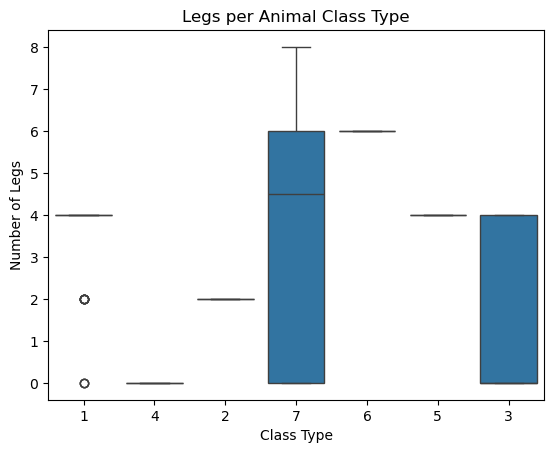

In [14]:
# Using Seaborn to plot a boxplot for leg feature

sns.boxplot(x='class_type', y='legs', data=df)
plt.title("Legs per Animal Class Type")
plt.xlabel("Class Type")
plt.ylabel("Number of Legs")
plt.show()


In [15]:
sns.pairplot(df, hue='class_type')


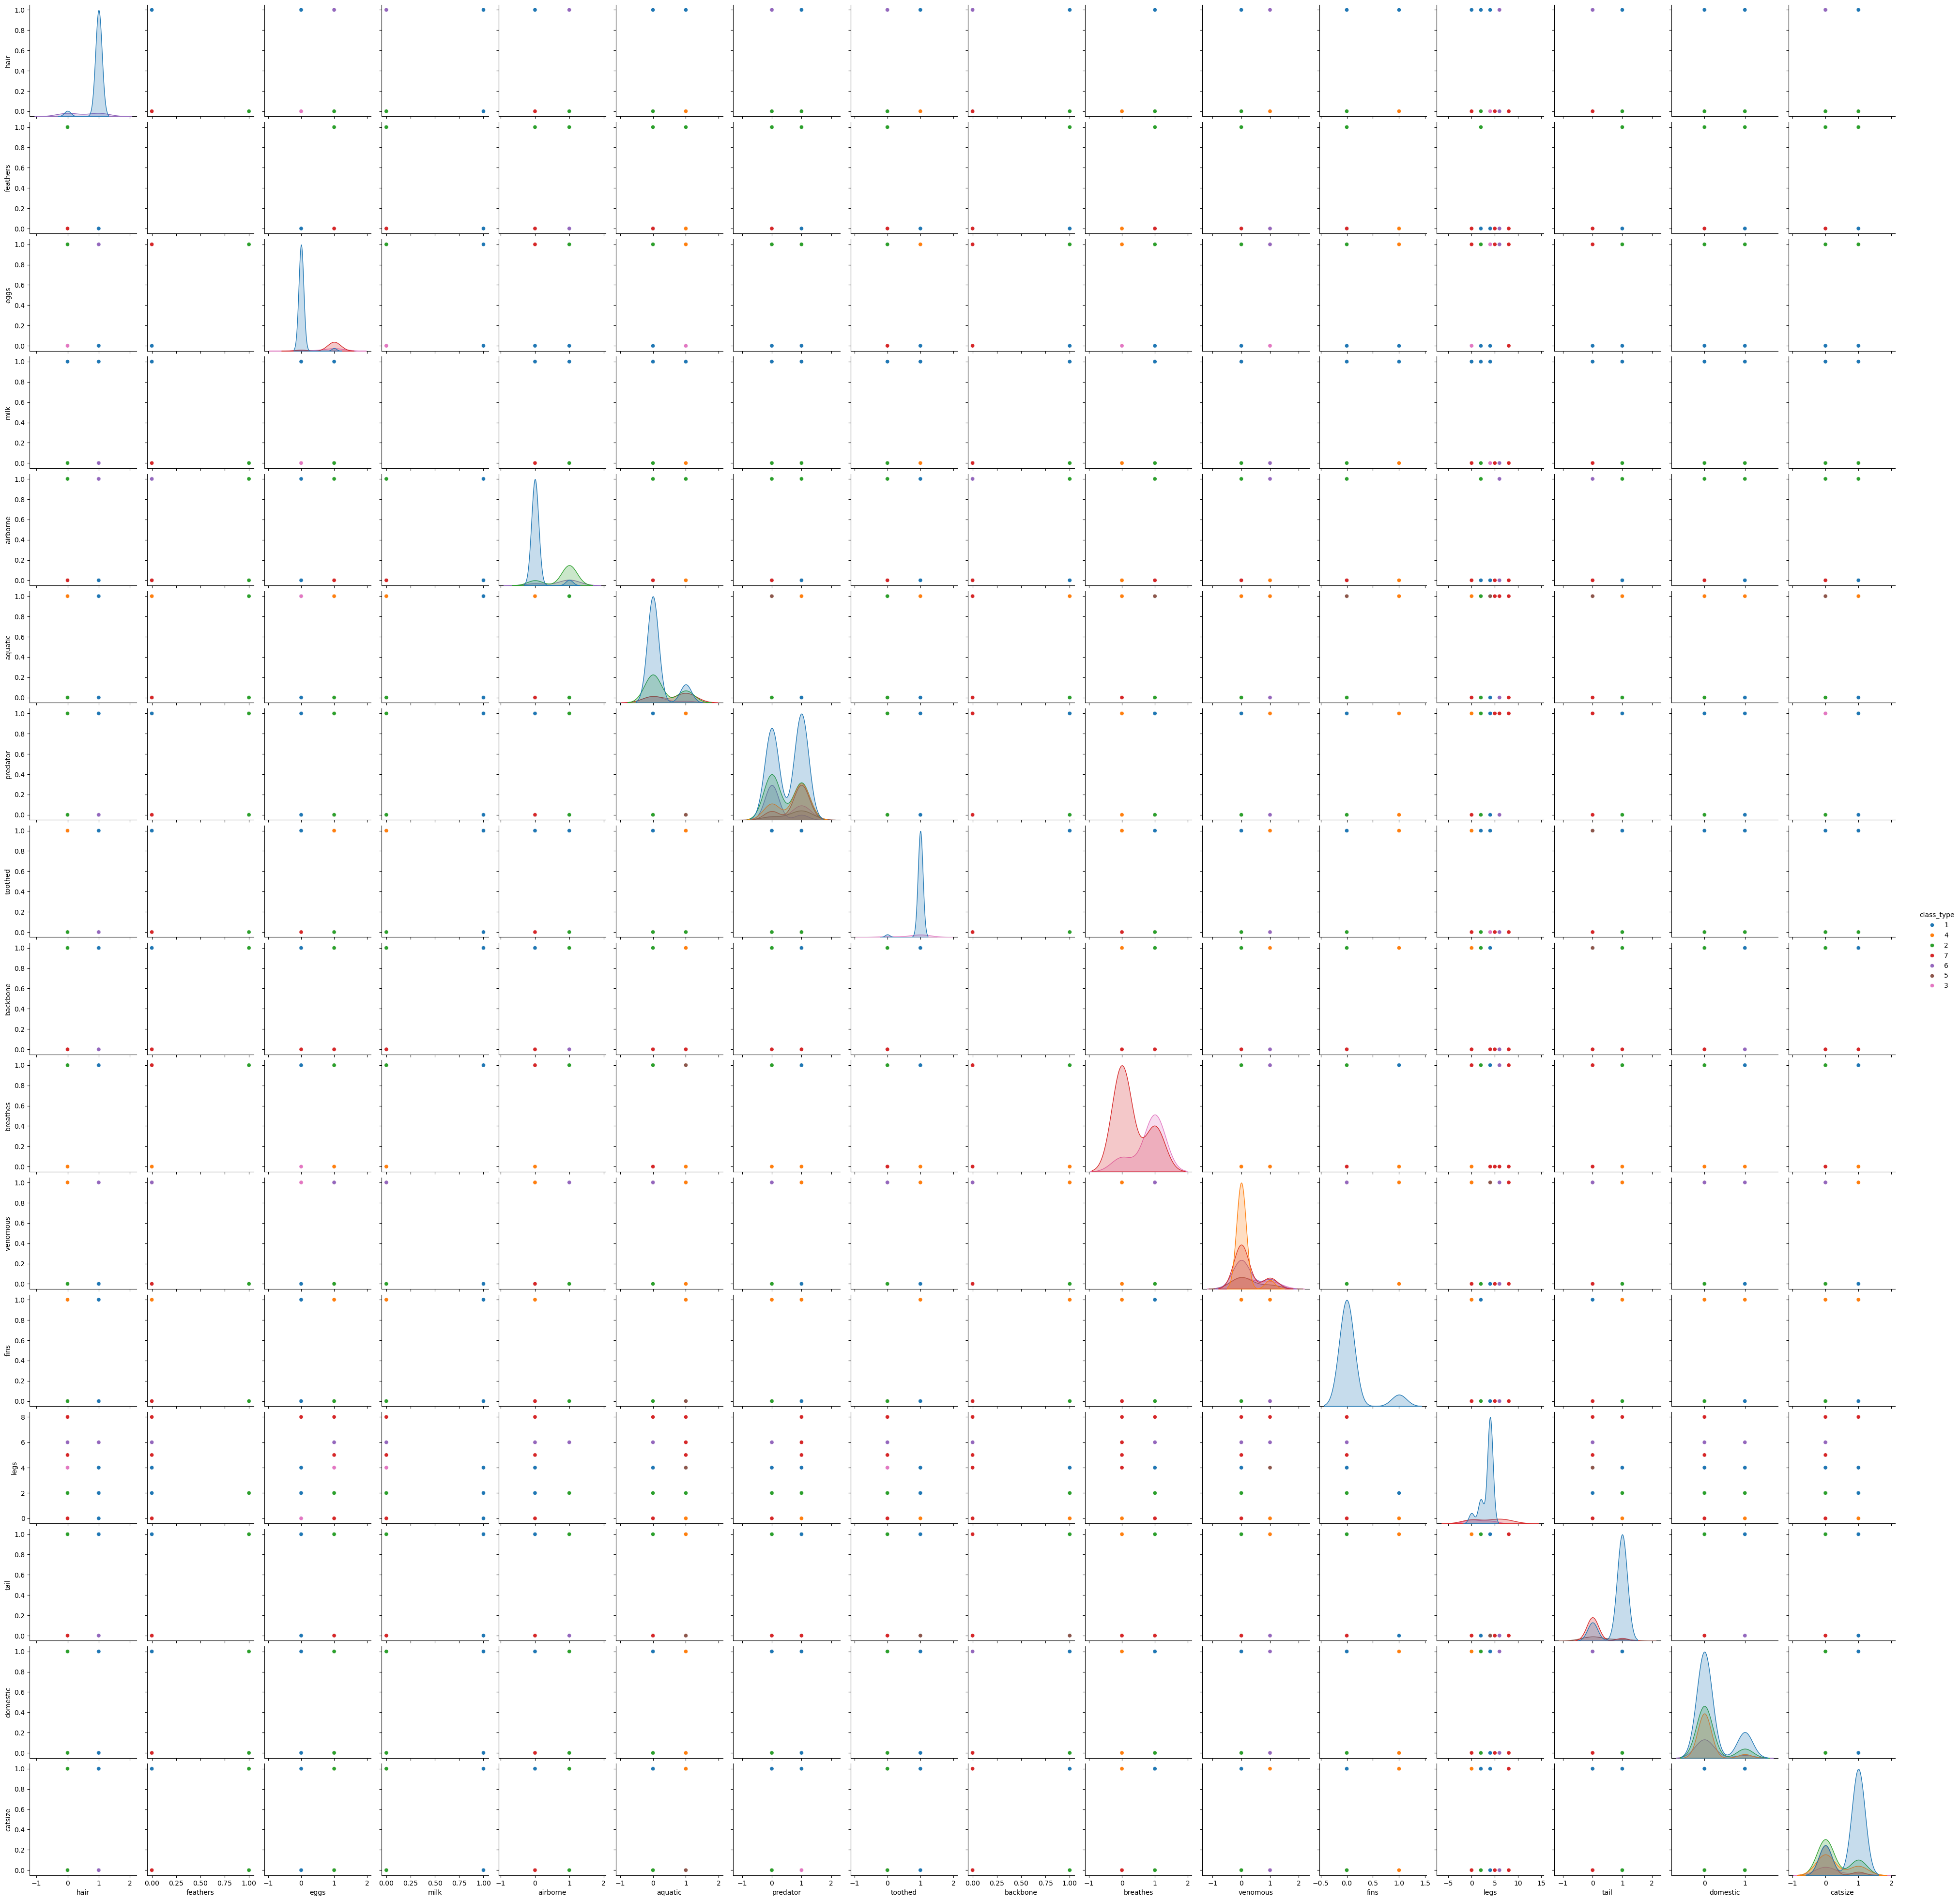

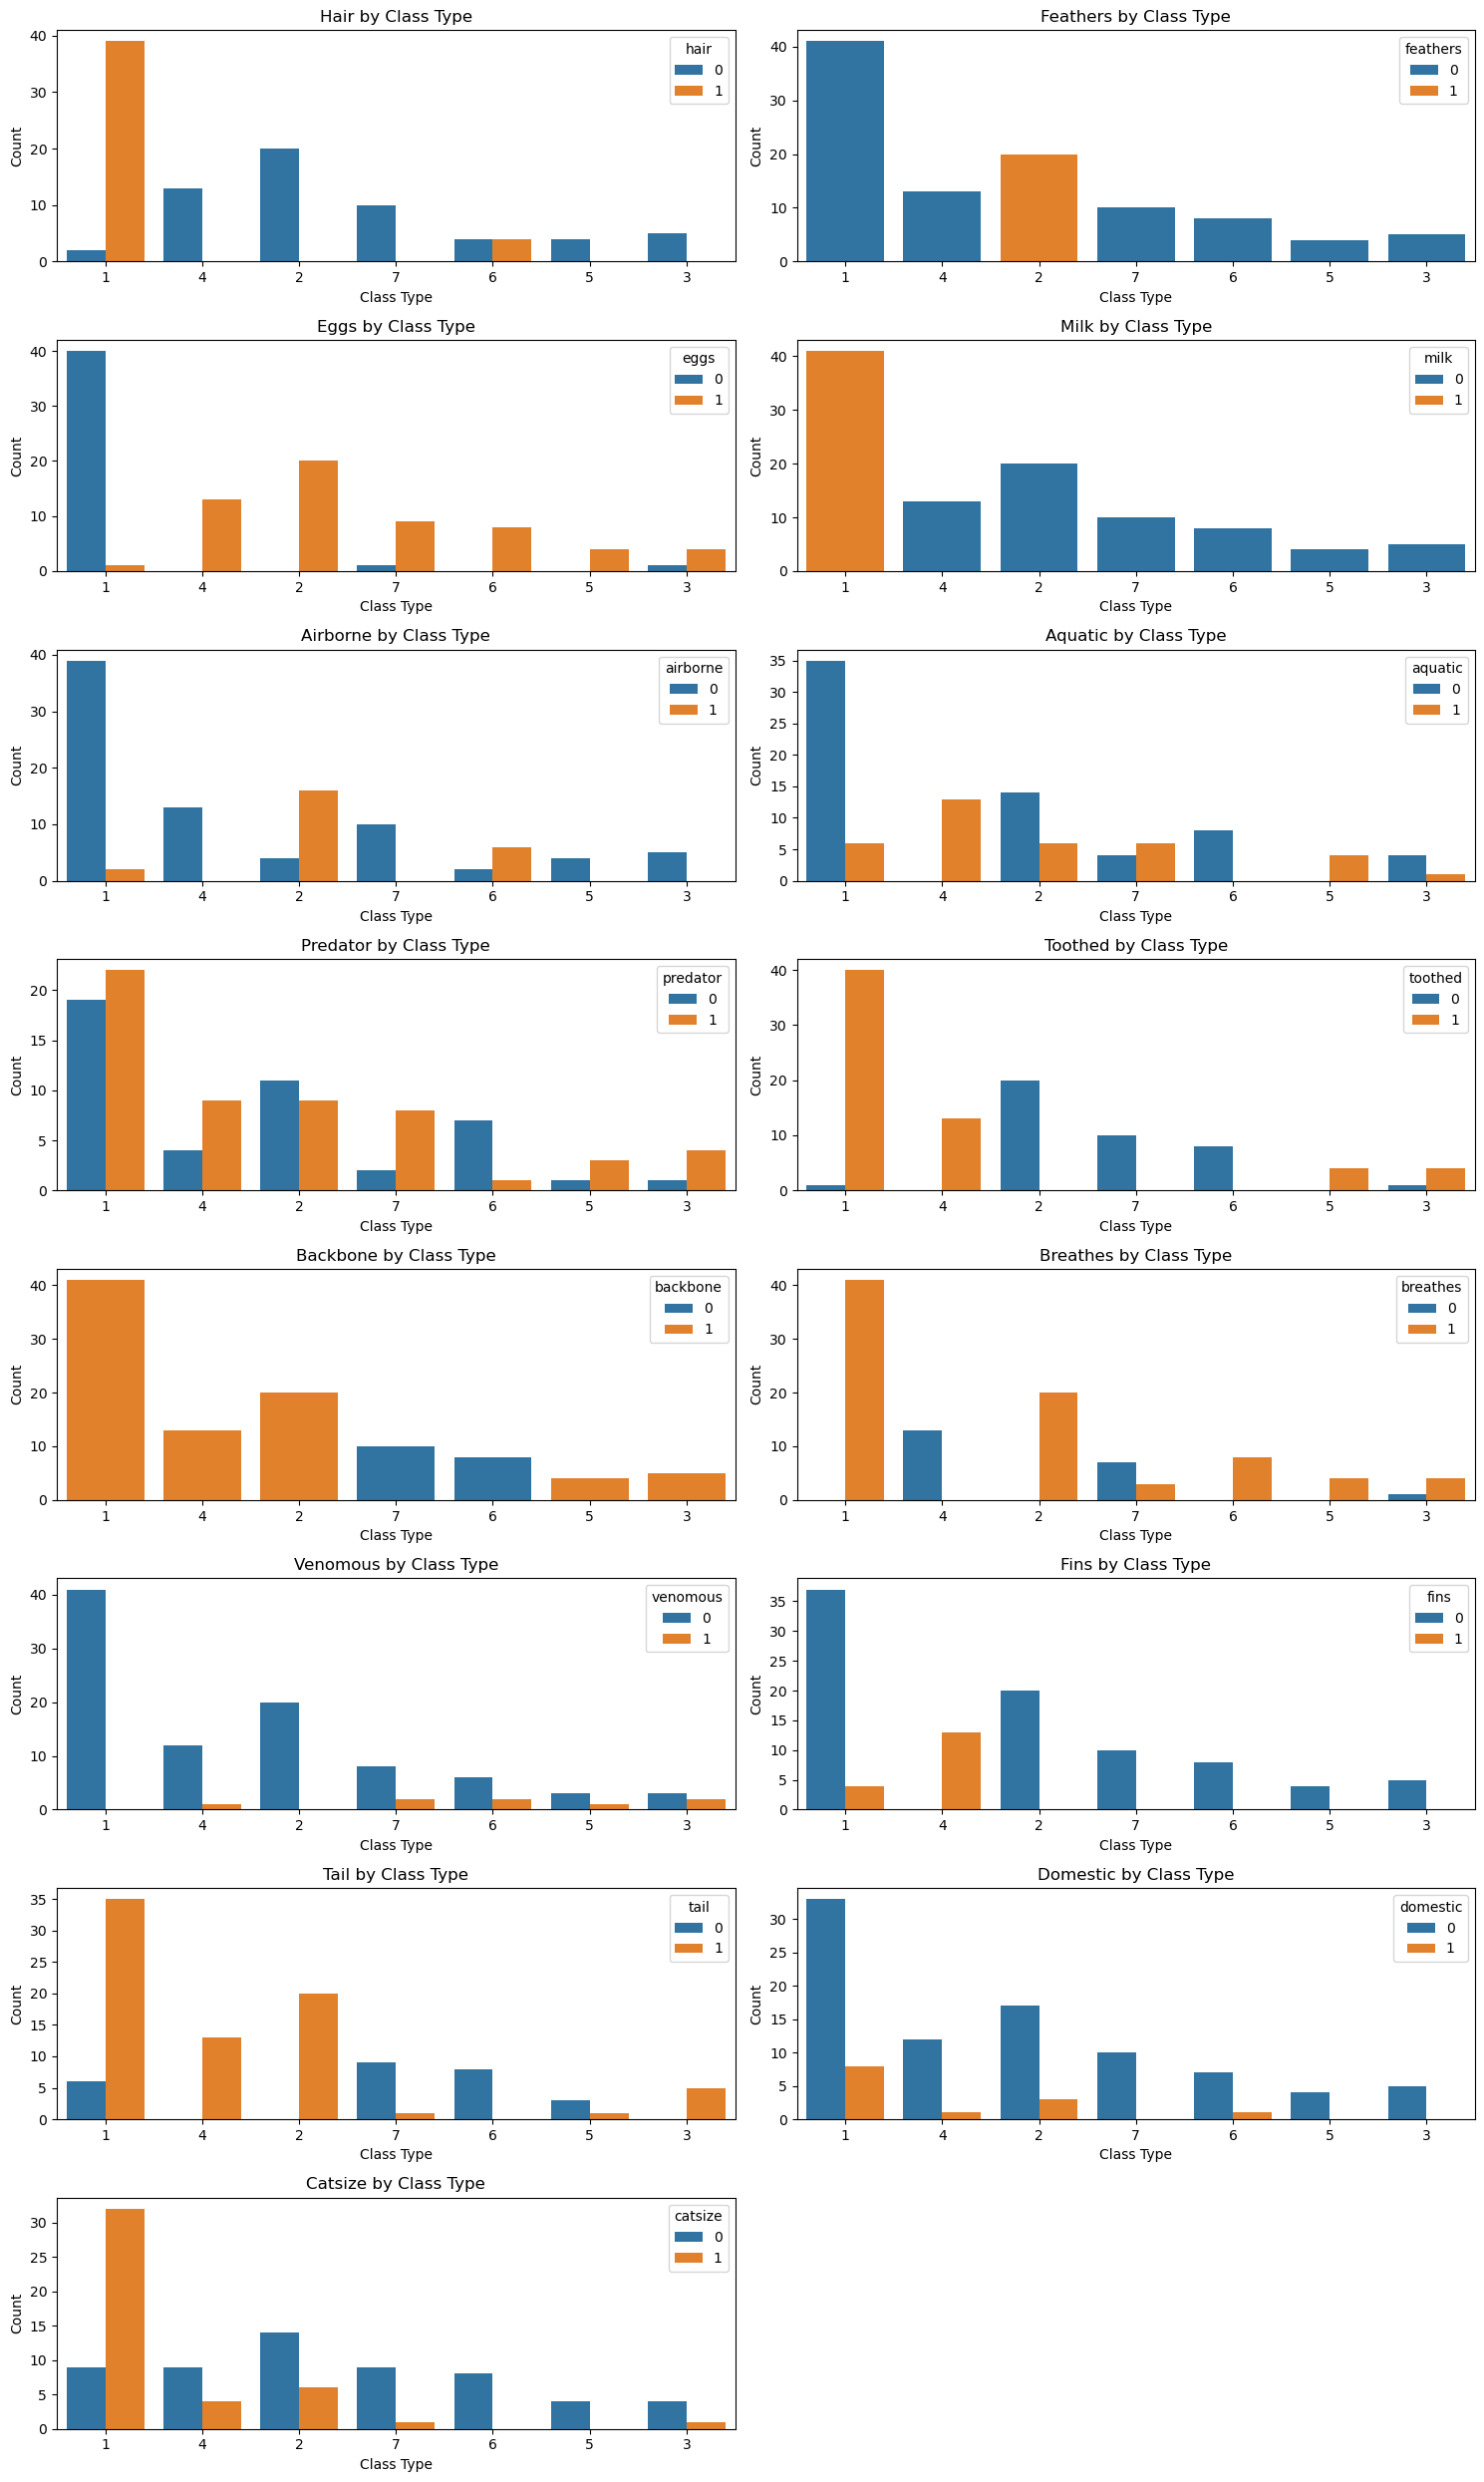

In [16]:
# Dashboard view of how traits vary between classes
# Using seaborn and Matplotlib

binary_features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 
                   'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'tail', 'domestic', 'catsize']

# Plot countplots for each binary feature grouped by class_type
plt.figure(figsize=(15, 25))
for i, feature in enumerate(binary_features, start=1):
    plt.subplot(8, 2, i)
    sns.countplot(x='class_type', hue=feature, data=df)
    plt.title(f"{feature.capitalize()} by Class Type")
    plt.xlabel("Class Type")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()


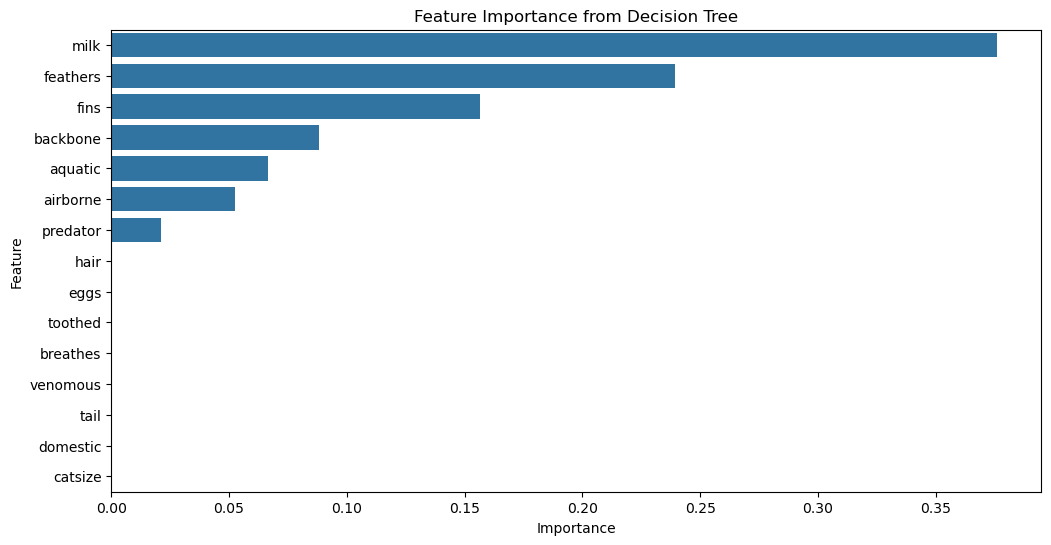

In [17]:
# Decision tree to tell us which features split the data best

# Train-test split
X_cleaned = df.drop(columns=['class_type', 'legs'])
y_cleaned = df['class_type']
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Fit model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Feature importance
importances = clf.feature_importances_

# Visualize
import pandas as pd
import matplotlib.pyplot as plt

feature_names = X_cleaned.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Decision Tree')
plt.show()


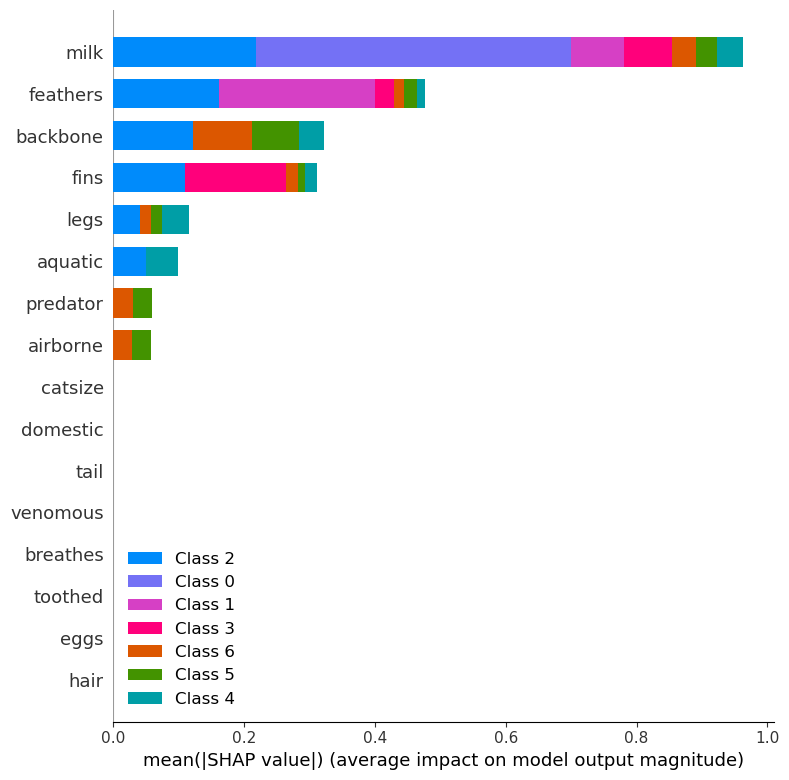

In [18]:
# USING SHAP MODULE
# Convert all columns in X to numeric where possible
X_cleaned = X.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values that resulted from the conversion
X_cleaned = X_cleaned.dropna()

# Optional: align y with cleaned X to make sure they're synced
y_cleaned = y.loc[X_cleaned.index]

clf = DecisionTreeClassifier()
clf.fit(X_cleaned, y_cleaned)

"""
This paints a picture of how each feature pushes or pulls the
prediction per class label—like a heatmap for model logic.
"""

explainer = shap.Explainer(clf, X_cleaned)
shap_values = explainer(X_cleaned)

# Summary plot
shap.summary_plot(shap_values, X)


The SHAP summary plot generated shows:

Which features are most important overall.

Whether high or low values of that feature push predictions up or down.

A color gradient—red means high values, blue means low.

### MODEL TRAINING

#### DECISION TREE

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         2
           5       0.00      0.00      0.00         0
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1

    accuracy                           0.95        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.95      0.95      0.95        21



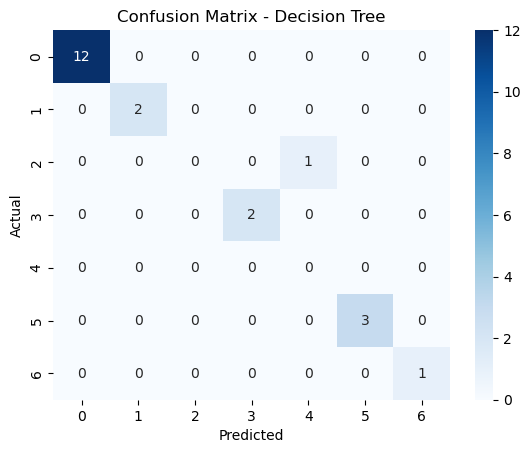

In [22]:
# DECISION TREE MODEL

# 1. Make sure 'legs' is numeric
df['legs'] = pd.to_numeric(df['legs'], errors='coerce')
df = df.dropna(subset=['legs'])

# 2. Scale 'legs' and add as a new column
scaler = StandardScaler()
df['legs_scaled'] = scaler.fit_transform(df[['legs']])

# 3. Drop 'class_type' and raw 'legs', keep 'legs_scaled'
X_cleaned = df.drop(columns=['class_type', 'legs'])
y_cleaned = df['class_type']

# 4. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# 5. Train your model as usual
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# 6. Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = dt_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# 7. Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### KNeighborsClassifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

y_knn_pred = knn_clf.predict(X_test)
print("KNN Report:")
print(classification_report(y_test, y_knn_pred))


KNN Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         1
           4       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1

    accuracy                           0.95        21
   macro avg       0.78      0.83      0.80        21
weighted avg       0.92      0.95      0.93        21



  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


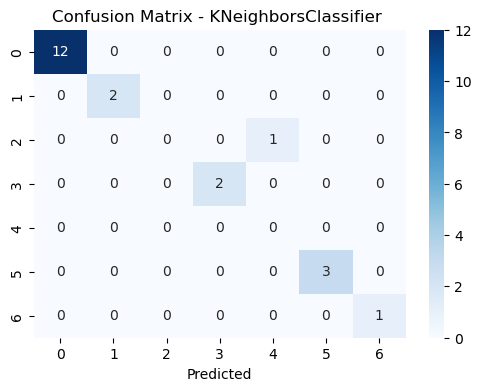

In [26]:
# VISUALIZED confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - KNeighborsClassifier ")
plt.xlabel('Predicted')
plt.show()


#### LogisticRegression

In [28]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)

y_log_pred = log_clf.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_log_pred))


Logistic Regression Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         1
           4       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1

    accuracy                           0.95        21
   macro avg       0.78      0.83      0.80        21
weighted avg       0.92      0.95      0.93        21



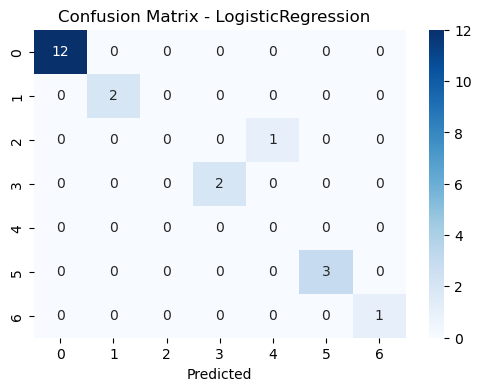

In [29]:
# VISUALIZED confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LogisticRegression  ")
plt.xlabel('Predicted')
plt.show()


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# 1. Train Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# 2. Train KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# 3. Train Logistic Regression
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# MODEL COMPARISON TABLE

models = {
    'Decision Tree': dt_clf,
    'KNN': knn_clf,
    'Logistic Regression': log_clf
}

scores = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    scores.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='macro', zero_division=0)
    })

import pandas as pd
score_df = pd.DataFrame(scores).sort_values(by='Accuracy', ascending=False)
print(score_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.952381   0.714286  0.714286  0.714286
1                  KNN  0.952381   0.777778  0.833333  0.800000
2  Logistic Regression  0.952381   0.777778  0.833333  0.800000


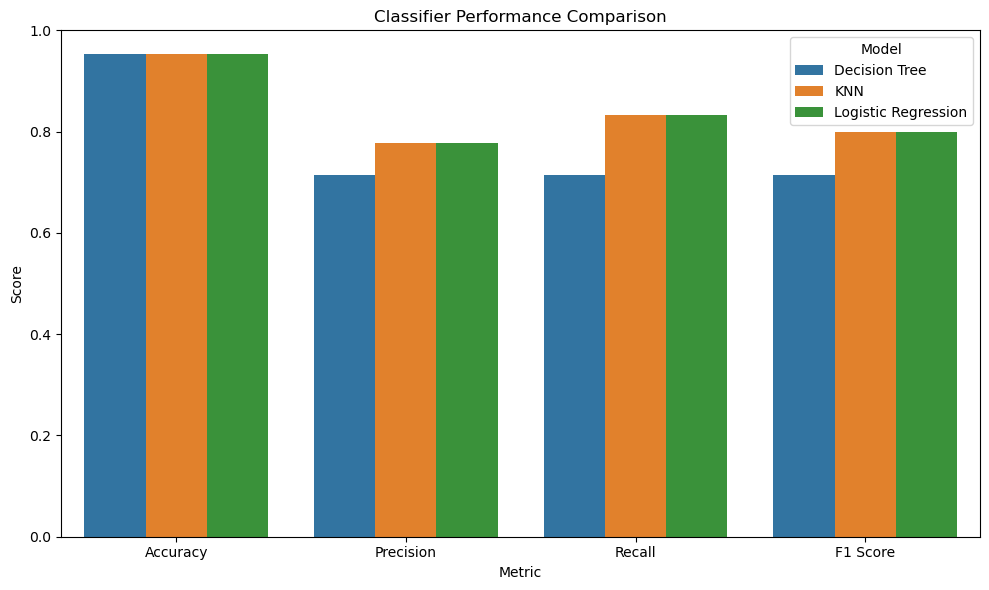

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# A bar chart to show off the top performing model

melted = score_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                       var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
plt.title('Classifier Performance Comparison')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


### Hyperparameter tuning

In [34]:
from sklearn.model_selection import GridSearchCV

# Tune Decision Tree

dt_params = {
    'max_depth': [3, 5, 7, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5)
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Params:", grid_dt.best_params_)


Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


In [35]:
# Tune KNN

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1: Manhattan, p=2: Euclidean
}

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
grid_knn.fit(X_train, y_train)

print("Best KNN Params:", grid_knn.best_params_)


Best KNN Params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [36]:
# Tune Logistic Regression

log_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

grid_log = GridSearchCV(LogisticRegression(max_iter=1000), log_params, cv=5)
grid_log.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_log.best_params_)


Best Logistic Regression Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


#### RE-TRAIN

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure your training and testing sets are defined
# X_train, X_test, y_train, y_test = ...

# 1. Retrain Decision Tree with best parameters
dt_clf = DecisionTreeClassifier(
    max_depth=grid_dt.best_params_['max_depth'],
    criterion=grid_dt.best_params_['criterion'],
    min_samples_split=grid_dt.best_params_['min_samples_split'],
    random_state=42
)
dt_clf.fit(X_train, y_train)

# 2. Retrain KNN with best parameters
knn_clf = KNeighborsClassifier(
    n_neighbors=grid_knn.best_params_['n_neighbors'],
    weights=grid_knn.best_params_['weights'],
    p=grid_knn.best_params_['p']
)
knn_clf.fit(X_train, y_train)

# 3. Retrain Logistic Regression with best parameters
log_clf = LogisticRegression(
    C=grid_log.best_params_['C'],
    penalty=grid_log.best_params_['penalty'],
    solver=grid_log.best_params_['solver'],
    max_iter=1000
)
log_clf.fit(X_train, y_train)

# 🏁 Store models in a dictionary for evaluation
models = {
    'Decision Tree': dt_clf,
    'KNN': knn_clf,
    'Logistic Regression': log_clf
}

# 📊 Evaluate each model and generate leaderboard
scores = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    scores.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='macro', zero_division=0)
    })

score_df = pd.DataFrame(scores).sort_values(by='Accuracy', ascending=False)
print(score_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.952381   0.714286  0.714286  0.714286
1                  KNN  0.952381   0.777778  0.833333  0.800000
2  Logistic Regression  0.952381   0.777778  0.833333  0.800000


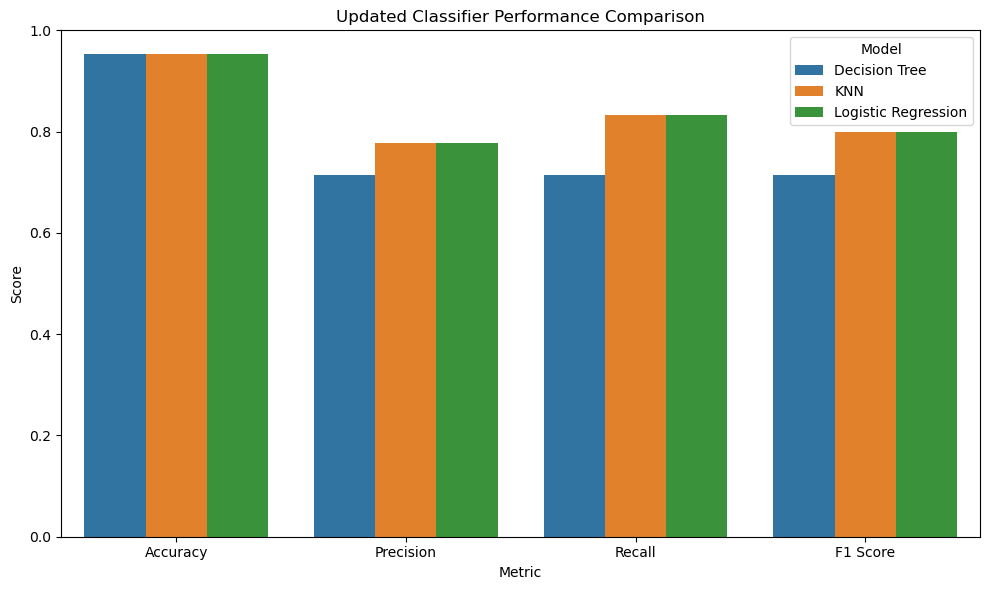

In [39]:
melted = score_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                       var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
plt.title('Updated Classifier Performance Comparison')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


#### ENSEMBLE LEARNING: Throw Decision Tree, KNN, and Logistic Regression into one unified model

In [41]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('dt', dt_clf),
        ('knn', knn_clf),
        ('logreg', log_clf)
    ],
    voting='hard'  # or 'soft' if using probabilistic output
)

voting_clf.fit(X_train, y_train)
y_vote_pred = voting_clf.predict(X_test)

print("Ensemble VotingClassifier Report:")
print(classification_report(y_test, y_vote_pred))

# Optional: Add it to your leaderboard
ensemble_score = {
    'Model': 'Voting Ensemble',
    'Accuracy': accuracy_score(y_test, y_vote_pred),
    'Precision': precision_score(y_test, y_vote_pred, average='macro', zero_division=0),
    'Recall': recall_score(y_test, y_vote_pred, average='macro', zero_division=0),
    'F1 Score': f1_score(y_test, y_vote_pred, average='macro', zero_division=0)
}

score_df = pd.concat([score_df, pd.DataFrame([ensemble_score])], ignore_index=True)
print(score_df.sort_values(by='Accuracy', ascending=False))



Ensemble VotingClassifier Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         1
           4       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1

    accuracy                           0.95        21
   macro avg       0.78      0.83      0.80        21
weighted avg       0.92      0.95      0.93        21

                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.952381   0.714286  0.714286  0.714286
1                  KNN  0.952381   0.777778  0.833333  0.800000
2  Logistic Regression  0.952381   0.777778  0.833333  0.800000
3      Voting Ensemble  0.952381   0.777778  0.833333  0.800000


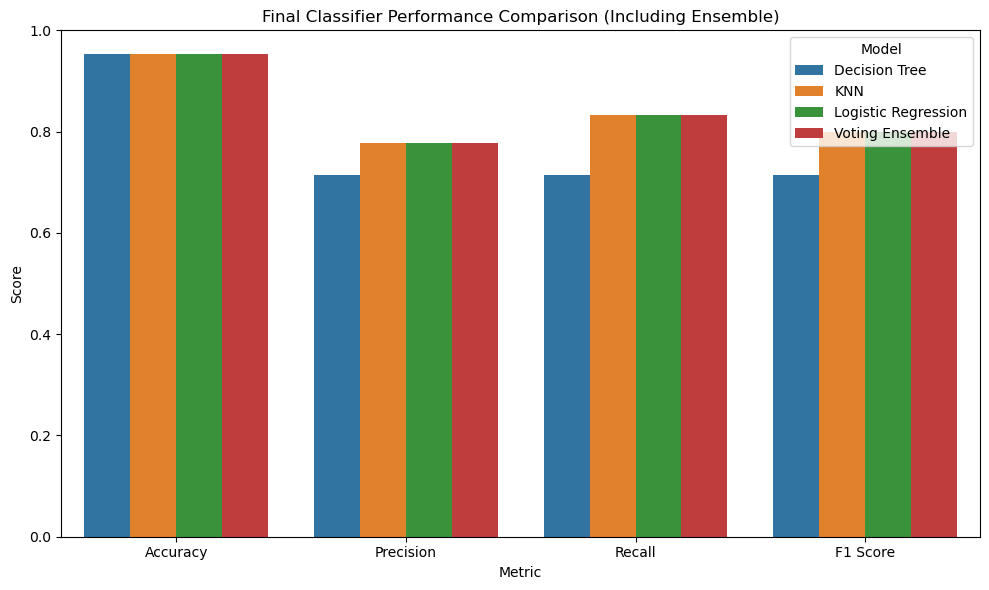

In [42]:
# Visualize Leaderboard with updated Ensemble

melted = score_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                       var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
plt.title('Final Classifier Performance Comparison (Including Ensemble)')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


### ROC CURVE WITH OneVsRestClassifier

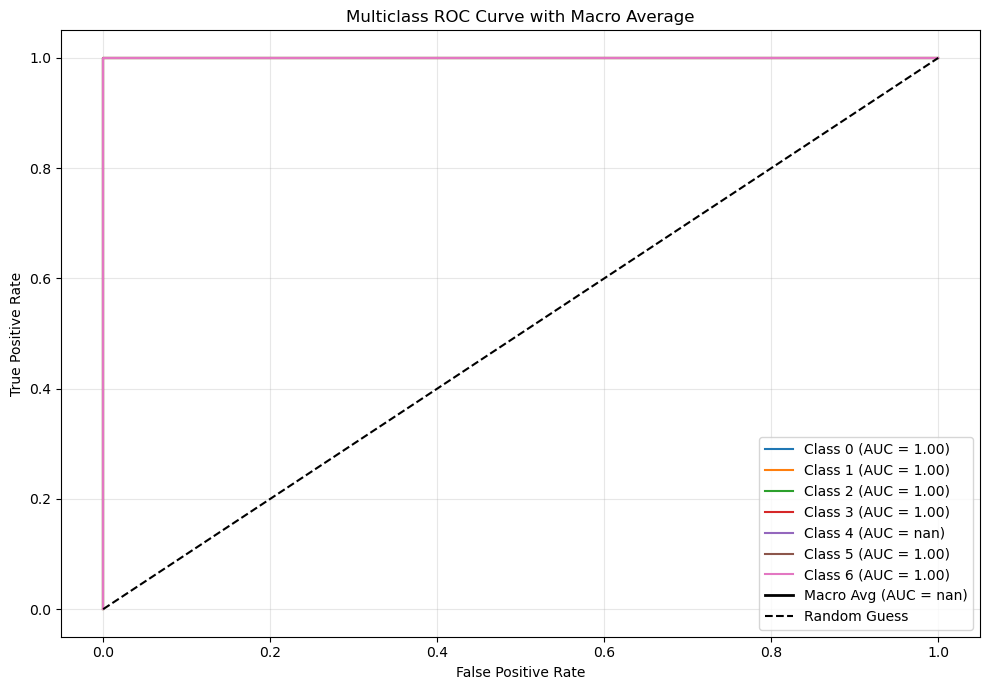

In [51]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Rebuild ensemble with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('dt', dt_clf),
        ('knn', knn_clf),
        ('logreg', log_clf)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)


# Re-binarize labels
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
n_classes = y_test_bin.shape[1]

# Use OneVsRest wrapper on your ensemble model or any other
ovr_clf = OneVsRestClassifier(voting_clf)
y_score = ovr_clf.fit(X_train, y_train).predict_proba(X_test)

# Compute per-class ROC curves and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, label=f'Macro Avg (AUC = {macro_auc:.2f})', color='black', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Multiclass ROC Curve with Macro Average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [54]:
import joblib

# Save the ensemble to a file
joblib.dump(voting_clf, 'zoo_classifier_ensemble.pkl')


['zoo_classifier_ensemble.pkl']

In [72]:
loaded_model = joblib.load('zoo_classifier_ensemble.pkl')
# Make predictions
loaded_model.predict(X_test)


array(['1', '1', '1', '1', '1', '6', '1', '1', '1', '1', '4', '6', '6',
       '2', '7', '1', '1', '2', '4', '1', '4'], dtype=object)